In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra, ieti_cy
from pyiga import assemble
#from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists
import itertools
from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)
import numba as nb    
#from numba import njit

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
class IetiDP:
    def __init__(self, MP, dir_data, neu_data=None, elim=True):
        self.space = MP
        self.elim = elim
        
        self.dir_idx=dict()
        self.dir_vals=dict()
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(self.dir_idx[p], return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
        
        if self.elim:
            p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.space.intfs], dtype=np.int32).T
            self.Basisk, self.N_ofs, self.N, self.B = ieti_cy.pyx_compute_decoupled_coarse_basis(self.space.Basis.tocsc(), MP.N_ofs.astype(np.int32), p_intfs)
        else:
            self.Basisk = [scipy.sparse.identity(self.space.N[p]) for p in range(self.space.numpatches)]
            self.B = self.space.Constr
            
        self.N = [Ba.shape[1] for Ba in self.Basisk]
        self.N_ofs = np.cumsum([0]+self.N)
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]
        self.Basis=scipy.sparse.block_diag(self.Basisk).tocsr()
        self.P2Gk =[]
        
        for p in range(self.space.numpatches):
            X = self.Basisk[p].tocoo()
            idx = np.where(np.isclose(X.data,1))
            X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
            D = (X.T@self.Basisk[p]).sum(axis=1).A.ravel()
            #assert all(abs(D)>1e-12), 'D has zeros.'
            #S = scipy.sparse.spdiags(1/D,[0],len(D),len(D))
            self.P2Gk.append(X.T)
            I = np.zeros(self.Basisk[p].shape[0])
            if p in self.dir_idx:
                I[self.dir_idx[p]] = 1
                self.dir_idx[p] = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
        
        self.P2G = scipy.sparse.block_diag(self.P2Gk)
        if len(self.dir_idx)>0:
            self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        else:
            self.global_dir_idx = np.array([])
        self.free_dofs = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx)
        self.free_dofs_pp = [np.arange(self.N[p]) if p not in self.dir_idx else np.setdiff1d(np.arange(self.N[p]),self.dir_idx[p]) for p in range(self.space.numpatches)]
        
        #self.B = self.B @ scipy.sparse.block_diag(self.Basisk)
        
        nnz_per_col = self.B.getnnz(axis=0)
        self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.skeleton = np.union1d(self.intfs, self.global_dir_idx)
        
        self.Rbb = []
        self.Rii = []
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask = np.zeros(self.N[p], dtype=bool)
            nnz_per_col = self.Bk[p].getnnz(axis=0)
            if p in self.dir_idx:
                intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.dir_idx[p])
            else:
                intfs = np.where(nnz_per_col > 0)[0]
            mask[intfs]=True
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rbb.append(Id[mask].tocsc())
            mask = np.ones(self.N[p], dtype=bool)
            mask[intfs]=False
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rii.append(Id[mask].tocsc())
            
        
    def assemble(self, problem, f):
        Ak = [Ba.T @ assemble.assemble(problem, kvs, bfuns=[('u',1), ('v',1)], geo=geo)@Ba for Ba, ((kvs, geo),_) in zip(self.Basisk, self.space.mesh.patches)]
        A = scipy.sparse.block_diag(Ak, format='csr')
        rhsk = [Ba.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f).ravel() for Ba, ((kvs, geo),_) in zip(self.Basisk,self.space.mesh.patches)]

        # self.Abb = self.Rbb.dot(A).dot(self.Rbb.T)
        # self.Aii = self.Rii.dot(A).dot(self.Rii.T)
        # self.Abi = self.Rbb.dot(A).dot(self.Rii.T)
        # self.Aib = self.Abi.T
        
        self.BCRestr = {p:assemble.RestrictedLinearSystem(Ak[p], rhsk[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        self.rhsk = [rhsk[p] if p not in self.dir_idx else self.BCRestr[p].b for p in range(self.space.numpatches)]
        self.Ak = [Ak[p] if p not in self.dir_idx else self.BCRestr[p].A for p in range(self.space.numpatches)]
        self.A = scipy.sparse.block_diag(self.Ak)
        # self.A = BCRestr.A
        # self.rhs = BCRestr.b
        
    def generate_prim(self, elim, fat):
        Nodes = self.space.get_nodes()
        self.Prim = {}
        i=0
        total_dofs=set()
        
        if elim:
            if fat:
                for key in Nodes:
                    if isinstance(key,int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        dofs = self.Basis.tocsr()[Nodes[key][1],:].indices
                        for dof in dofs:
                            if dof not in total_dofs:
                                total_dofs.add(dof)
                                dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                                self.Prim[i] = (dofs,np.ones(len(dofs)))
                                i+=1
            else:
                for key in Nodes:
                    if isinstance(key,int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                        coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                        dofs_coarse = self.Basis.tocsr()[Nodes[key][1],:].indices
                        dofs=[]
                        for dof in dofs_coarse:
                            found_dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                            dofs.append(found_dofs)
                        self.Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
                        i+=1
        else:
            for key in Nodes:
                if isinstance(key,int32):
                    dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                    self.Prim[i] = (dofs,np.ones(len(dofs)))
                    i+=1
                else:
                    constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                    coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                    dofs_coarse = Nodes[key][1]
                    dofs=np.concatenate([Nodes[key][0],Nodes[key][1]])
                    coeffs = np.concatenate([np.ones(len(Nodes[key][0])),coeffs])
                    self.Prim[i] = (dofs,coeffs)
                    i+=1
        
    def construct_primal_constraints(self, redundant=False, fat=True):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes(dir_boundary = True)
        
        self.generate_prim(elim=self.elim, fat=fat)

        if self.Prim:
            loc_c_prim = np.concatenate([self.Prim[key][0] for key in self.Prim])
            coeffs = np.concatenate([self.Prim[key][1] for key in self.Prim])
        else:
            loc_c_prim = np.array([])
            coeffs = np.array([])
        loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i][0]) for i in self.Prim])
        p_idx = [(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1]) for p in range(self.space.numpatches)]
        self.Prim_pp = {p : (loc_c_prim[p_idx[p]],coeffs[p_idx[p]],loc_c_prim_idx[p_idx[p]]) for p in range(self.space.numpatches)}

        for p in range(MP.numpatches):
            c_primal_free = self.Prim_pp[p][0] - self.N_ofs[p]
            data = self.Prim_pp[p][1]
            idx = np.bincount(self.Prim_pp[p][2])
            idx = idx[idx>0]
            rows = np.repeat(np.arange(len(idx)),idx)
            cols = c_primal_free
            ck = coo_matrix((data, (rows, cols)),(len(idx),self.N[p])).tocsc()
            ck = ck[:,self.free_dofs_pp[p]]
            self.Ck.append(ck.tocsr())
            m, n = ck.shape[0], len(self.Prim)
            jj = np.unique(self.Prim_pp[p][2])
            self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
            
        if not redundant:
            if self.elim:
                if fat:
                    nnz_per_row = self.B[:,np.concatenate([self.Prim_pp[p][0] for p in range(self.space.numpatches)])].getnnz(axis=1)
                    self.eliminate_constraints = np.where(nnz_per_row > 0)[0]
                else:
                    dofs = [Nodes[key][0] for key in Nodes if isinstance(key,int32)]
                    if len(dofs)>0:
                        dofs = np.concatenate([Nodes[key][0] for key in Nodes if isinstance(key,int32)])
                    dofs_new = (self.Basis[dofs,:]==1).indices
                    self.eliminate_constraints = np.where(self.B[:,dofs_new].getnnz(axis=1))
            else:
                self.eliminate_constraints = (MP.Constr.tocsc()[:,np.concatenate([Nodes[key][0] for key in Nodes])]==1).indices
                    
        
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_basis(self):
        self.PsiK=[]
        self.Deltak=[]
        self.loc_solver = []
        self.A_prim = np.zeros(2*(len(self.Prim),))
        for p in range(len(self.space.mesh.patches)):
            a = self.Ak[p]
            c = self.Ck[p]
            RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
            self.loc_solver.append(solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True))
            psi = self.loc_solver[p].dot(RHS)
            psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            self.PsiK.append(psi@self.Rk[p])
            self.Deltak.append(delta)
            self.A_prim -= self.Rk[p].T@delta@self.Rk[p]

        self.Psi=np.vstack(self.PsiK)
        
    def remove_dir_from_jumps(self):
        self.B = self.B[:,self.free_dofs]
        keep = np.where(self.B.getnnz(axis=1)>0)[0]
        self.B=self.B[keep,:]
        idx_p = [(self.free_dofs < self.N_ofs[p+1]) & (self.free_dofs >= self.N_ofs[p]) for p in range(self.space.numpatches)]
        self.Bk = [self.B[:,idx_p[p]] for p in range(self.space.numpatches)]
        
    def compute_F(self):
        #Bk = [b[np.where(b.getnnz(axis=1)>0)[0]] for b in Bk]
        self.Bk_ = [aslinearoperator(scipy.sparse.bmat([[b,np.zeros((b.shape[0],self.Ck[p].shape[0]))]], format='csr')) for p,b in enumerate(self.Bk)] 
        #PTAP = self.A_prim#self.Psi.T@self.A@self.Psi
        #PTBT = self.Psi.T@self.B.T
        BP   = self.B@self.Psi
        
        rhs = np.concatenate(self.rhsk)
        self.rhsk_ = [np.concatenate([f,np.zeros(self.Ck[p].shape[0])]) for p,f in enumerate(self.rhsk)]
        
        #self.loc_solver = [solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True) for a,c in zip(self.Ak, self.Ck)]
        self.solver_prim = solvers.make_solver(self.A_prim, spd=True, symmetric=True)
        F1 = aslinearoperator(BP@self.solver_prim.dot(BP.T)) 
        F2 = sum([b@Ak_inv.dot(b.T) for b, Ak_inv in zip(self.Bk_, self.loc_solver)])

        b1 = BP@self.solver_prim.dot(self.Psi.T@rhs)
        b2 = np.sum([b.dot(Ak_inv.dot(f)) for b, Ak_inv,f in zip(self.Bk_, self.loc_solver, self.rhsk_)],axis=0)

        #print(self.solver_prim.dot(self.Psi.T@rhs))
        #print([b.dot(Ak_inv.dot(f)) for b, Ak_inv,f in zip(self.Bk_, self.loc_solver, rhsk_)])
        
        return F1+F2, b1+b2
    
    def MsD(self, method="diagonal"):
        B = self.B
        Bk = self.Bk
        Rb = [self.Rbb[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]
        Ri = [self.Rii[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]
        self.B_gamma = scipy.sparse.hstack([Bk[p]@Rb[p].T for p in range(self.space.numpatches)])

        self.Abb = [aslinearoperator(Rb[p]@self.Ak[p]@Rb[p].T) for p in range(self.space.numpatches)]
        self.Aii = [Ri[p]@self.Ak[p]@Ri[p].T for p in range(self.space.numpatches)]
        self.Abi = [aslinearoperator(Rb[p]@self.Ak[p]@Ri[p].T) for p in range(self.space.numpatches)]
        
        self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(self.Abb,self.Abi,self.Aii)]
        ofs = np.cumsum([0]+[s.shape[0] for s in self.S])
        
        if method=="pseudo":   ###TODO: Do not compute matrix exactly but use least squares as an operator
            t=time.time()
            P = np.linalg.pinv(self.B_gamma.A)
            P[abs(P)<1e-12]=0
            self.BgD=scipy.sparse.csr_matrix(P).T
            print("Computing pseudoinverse took "+str(time.time()-t)+" seconds.")
        elif method=="diagonal":
            D = self.B_gamma.getnnz(axis=0)
            D = 1/(1+D)
            self.D = scipy.sparse.diags(D, format='csr')
            self.BgD = self.B_gamma@self.D
        elif method=="selection":
            B = self.B_gamma.tocsc()
            idx = 1*(B.indptr[1:]-B.indptr[:-1]==1) & np.isclose(B.sum(axis=0).A[0],1)
            self.D=scipy.sparse.diags([idx],[0])
            self.BgD = self.B_gamma@self.D
        print("Convergence condition: "+str(scipy.sparse.linalg.norm(self.B_gamma@self.BgD.T@self.B_gamma-self.B_gamma)))
        # for p in range(self.space.numpatches):
        #     print(self.BgD[:,ofs[p]:ofs[p+1]].shape, self.S[p].shape, self.BgD[:,ofs[p]:ofs[p+1]].T.shape)
        return sum([aslinearoperator(self.BgD[:,ofs[p]:ofs[p+1]])@self.S[p].dot(aslinearoperator(self.BgD[:,ofs[p]:ofs[p+1]].T)) for p in range(self.space.numpatches)])

    def construct_solution(self, lam):
        u=[]
        u_prim = self.solver_prim.dot(self.Psi.T@(np.concatenate(self.rhsk)-self.B.T@lam))
        for p in range(self.space.numpatches):
            sol = self.loc_solver[p].dot(np.r_[self.rhsk[p]-self.Bk[p].T@lam,np.zeros(self.Ck[p].shape[0])])[:self.Ck[p].shape[1]]
            #print(sol.shape)
            sol += self.PsiK[p]@u_prim
            if p in self.BCRestr:
                sol = self.BCRestr[p].complete(sol)
            u.append(self.Basisk[p]@sol)
        return u
        

In [3]:
def checkerboard1(deg,N,k):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((2,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    geometry.unit_square().translate((2,1)),
    geometry.unit_square().translate((0,2)),
    geometry.unit_square().translate((1,2)),
    geometry.unit_square().translate((2,2)),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==1})
    return M

In [4]:
def checkerboard2(deg,N,k):
    geos = [
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6),
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6).rotate_2d(np.pi/3),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6).rotate_2d(np.pi/3),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6).rotate_2d(np.pi/3),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==1})
    return M

In [5]:
def Lshape(deg, N, depth=0):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.annulus(r1=1.5,phi=np.pi/4),
        geometry.annulus(r1=1.5,phi=np.pi/4).rotate_2d(np.pi/4),
        geometry.annulus(r1=1,r2=1.5,phi=np.pi/4).rotate_2d(np.pi/4),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    for i in range(depth):
        refine = np.where([np.any([np.array_equal(row,1.5*np.array([np.cos(np.pi/4),np.sin(np.pi/4)])) for row in topology.corners(geo,ravel=1)]) for geo in M.geos])[0]
        M.h_refine({patch:None for patch in refine})
    
    return M

In [6]:
def Tshapes(deg,N,depth=0):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine({0:1})
    for i in range(depth):
        M.h_refine({j:0 for j in range(1,len(M.geos))})
    return M

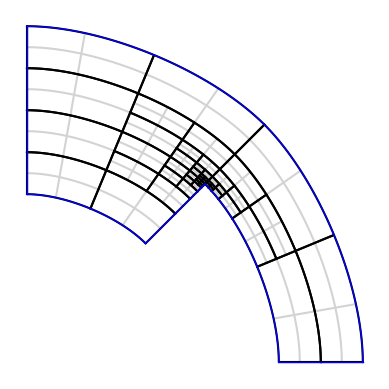

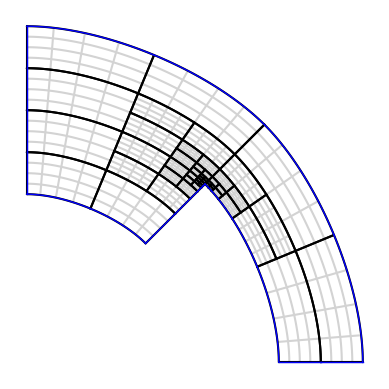

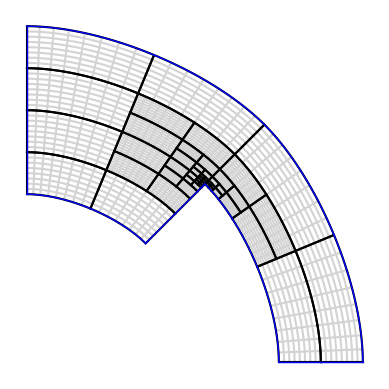

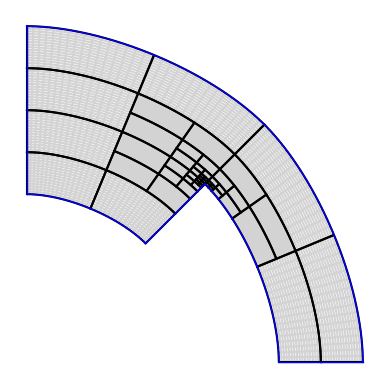

In [13]:
M = Lshape(1,2,5)
for i in range(4):
    M.draw(patch_idx=0, knots=1, bcolor={0:"blue"},nodes=0)
    axis('off');
    M.h_refine(-1);
    plt.savefig('Lshape'+str(i+1)+'.pdf',bbox_inches='tight');

In [15]:
len(M.geos)

48

In [7]:
M=Lshape(3,5,3)

In [28]:
M=checkerboard2(3,4,1)

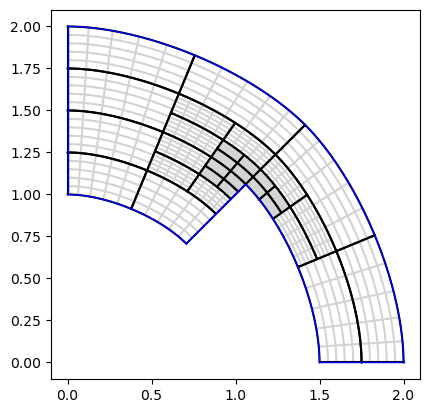

In [38]:
M.draw(patch_idx=0, knots=1, bcolor={0:"blue"})

In [39]:
M = Tshapes(3,5,5)

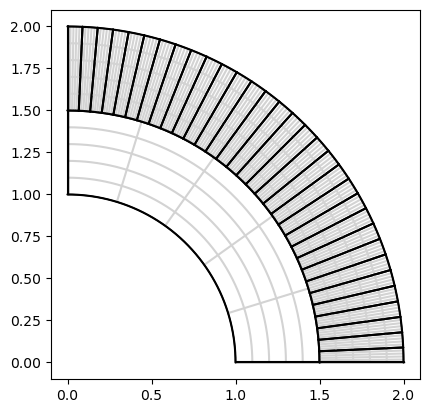

In [40]:
M.draw(knots=1)

In [27]:
np.cos(np.pi/4)*1.5

1.0606601717798214

In [22]:
topology.corners(M.geos[0])

array([[[1.5    , 0.     ],
        [2.     , 0.     ]],

       [[1.06066, 1.06066],
        [1.41421, 1.41421]]])

In [6]:
def example_geo(deg, N):
    patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.quarter_annulus())]
    M = topology.PatchMesh(patches)

    M.h_refine({0:0});
    M.h_refine({0:1});
    #M.h_refine({1:1});
    #M.h_refine({0:-1,3:-1});
    #M.h_refine({2:0});
    #M.h_refine({1:1});
    return M

setting up constraints took 0.0034437179565429688 seconds.
Basis setup took 0.005500316619873047 seconds


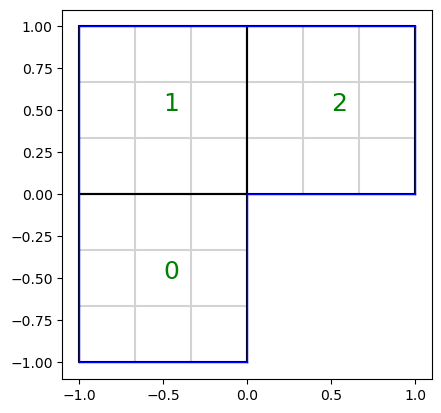

In [17]:
f = lambda x, y: x+y
g = lambda x, y: 0.

params = {'f' : f, 'g' : g}
deg = 2
N = 3
elim=0
fat=0

#M = checkerboard2(deg,N,1)
M = Lshape(deg,N,0)
#M = topology.PatchMesh(list(zip(5*(2*(bspline.make_knots(deg,0,1,N),),),geometry.mp_disk())))
MP = assemble.Multipatch(M, automatch=True)
dir_data = {0:g}
MP.set_dirichlet_boundary(dir_data)
MP.mesh.draw(patch_idx=1,nodes=0,knots=1,bcolor={0:'blue'})
I = IetiDP(MP, dir_data = {0:g}, elim=elim)
I.assemble(problem='(inner(grad(u),grad(v)))* dx',f=lambda x,y: x+y)
I.construct_primal_constraints(redundant=False, fat = fat)
I.construct_primal_basis()
I.remove_dir_from_jumps()
#F,b = I.compute_F()
#print(np.max(I.Psi))
#print(norm(b))
#MsD = I.MsD(method = "choice")
#x0 = None
#x0 = np.random.rand(len(b))
#lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=x0, maxiter=20000, P=MsD, output=1, rtol=1e-6, atol=1e-12)
#lam, info = scipy.sparse.linalg.cg(F, b, x0=x0, maxiter=2000, M = MsD, rtol=1e-5, atol=1e-12)
#print(info)
#print(min_eig, max_eig)
#u_loc0 = I.construct_solution(lam0)
#u_loc = I.construct_solution(lam)
#MP.plot(np.concatenate(u_loc))

In [22]:
MP.Constr[:,29].data

array([ 1., -1.])

setting up constraints took 0.019445180892944336 seconds.
Basis setup took 0.00829625129699707 seconds


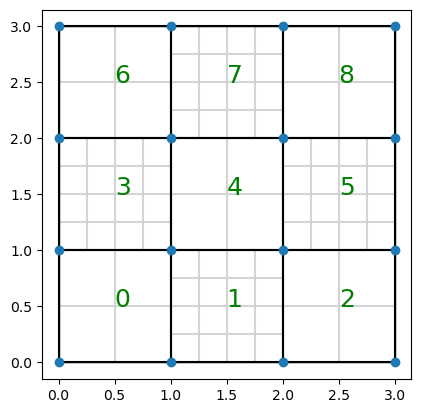

In [23]:
M = checkerboard1(deg,2,1)
MP = assemble.Multipatch(M, automatch=True)
MP.set_dirichlet_boundary({0:g})
MP.mesh.draw(patch_idx=1,nodes=1,knots=1)

deg = 2
setting up constraints took 0.07187962532043457 seconds.
Basis setup took 0.013956546783447266 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 6.624626344183713 stopped after 13 iterations with relres 6.626142175709995e-07
#####################################################
setting up constraints took 0.020641088485717773 seconds.
Basis setup took 0.008261442184448242 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 9.722160648221683 stopped after 14 iterations with relres 7.756187499118123e-07
#####################################################
setting up constraints took 0.025907516479492188 seconds.
Basis setup took 0.008754730224609375 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 13.048316627900547 stopped after 16 iterations with relres 9.755105946635363e-07
#####################################################
setting up constraints took 0.029692649841308594 seconds.
Basi

/home/wolfman/miniconda3/lib/python3.12/site-packages/pyiga-0.1.0-py3.12-linux-x86_64.egg/pyiga/topology.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=kwargs.get('figsize'))


Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 22.858411201381763 stopped after 18 iterations with relres 9.159423661181816e-07
#####################################################
setting up constraints took 0.03478550910949707 seconds.
Basis setup took 0.012675046920776367 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 27.68647838468237 stopped after 20 iterations with relres 3.8468391760856596e-07
#####################################################
setting up constraints took 0.04531979560852051 seconds.
Basis setup took 0.01822638511657715 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 32.94538310354471 stopped after 22 iterations with relres 3.005831480442891e-07
#####################################################
setting up constraints took 0.07680964469909668 seconds.
Basis setup took 0.038129568099975586 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 

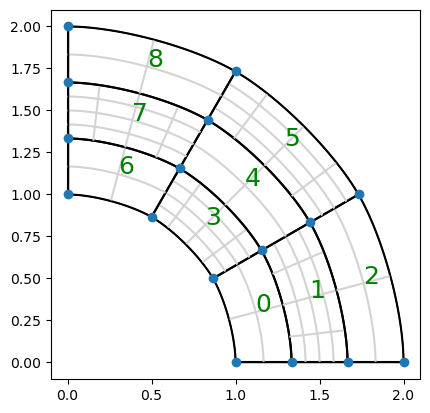

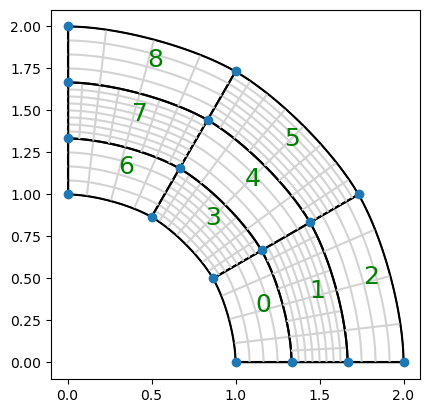

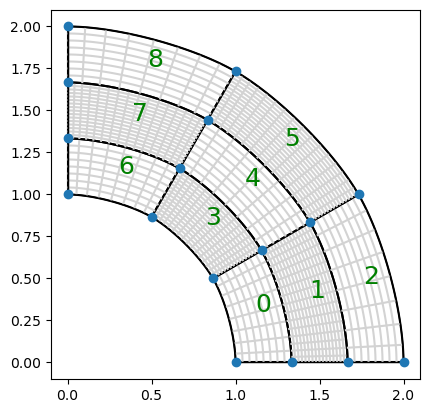

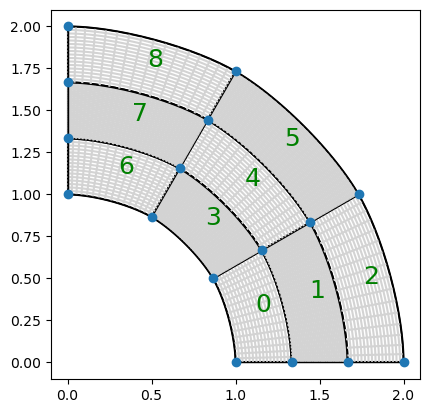

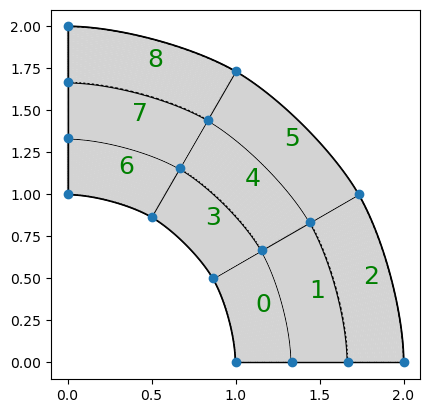

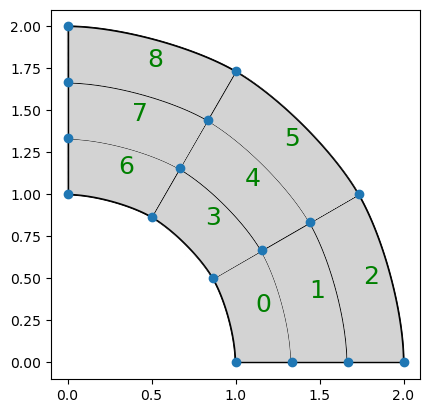

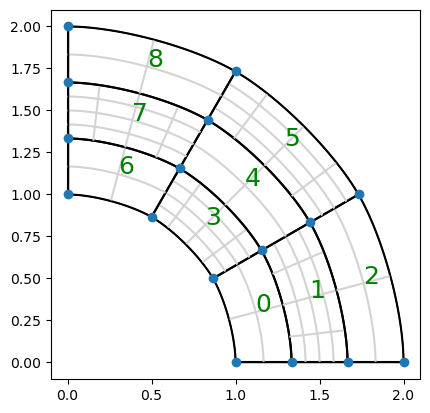

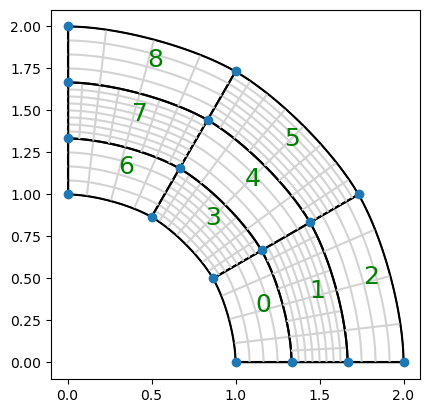

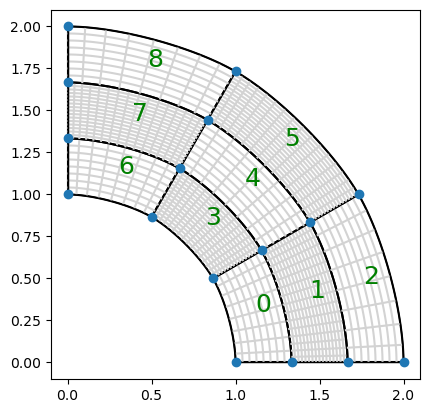

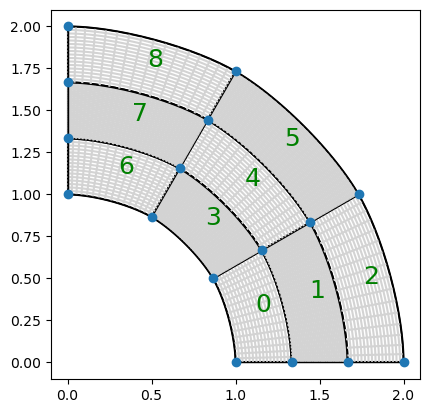

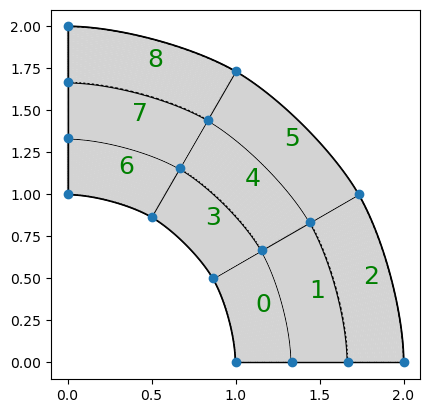

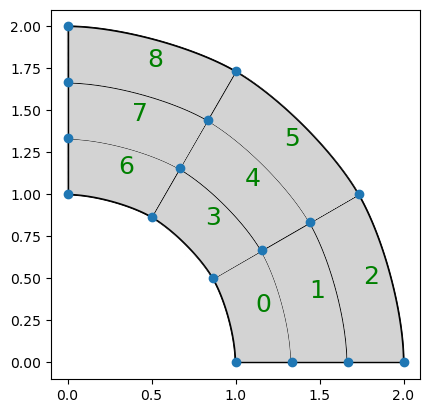

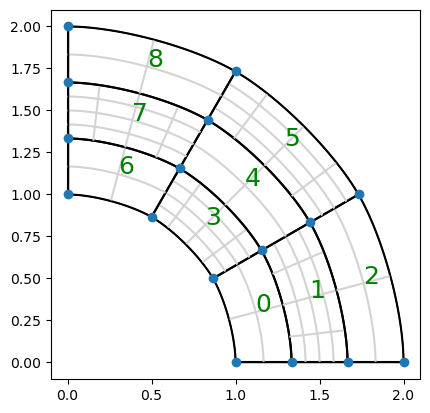

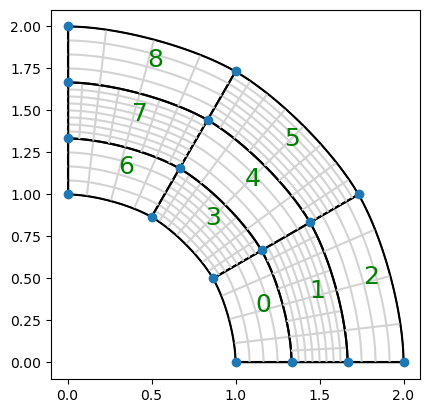

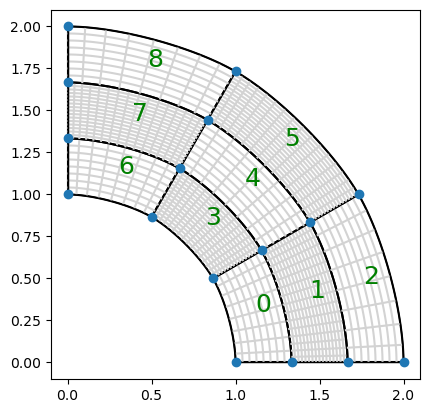

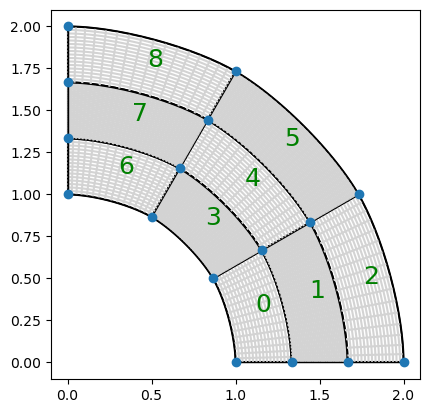

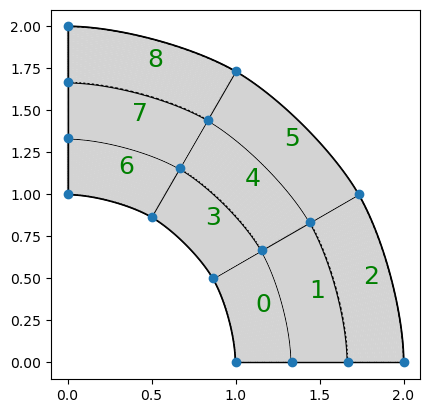

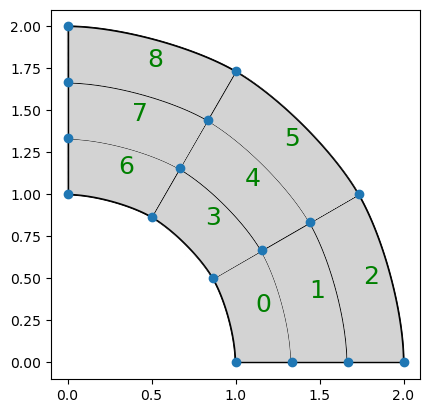

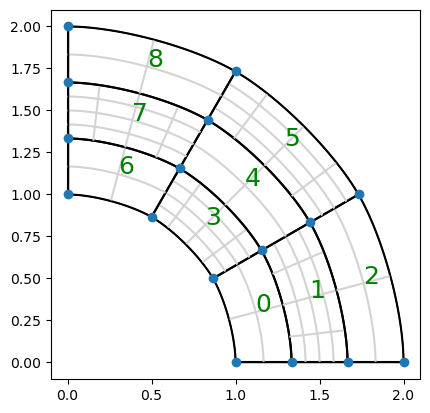

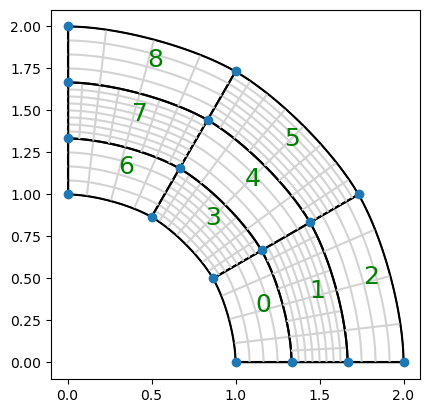

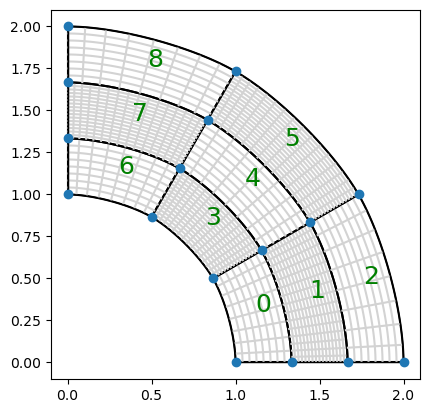

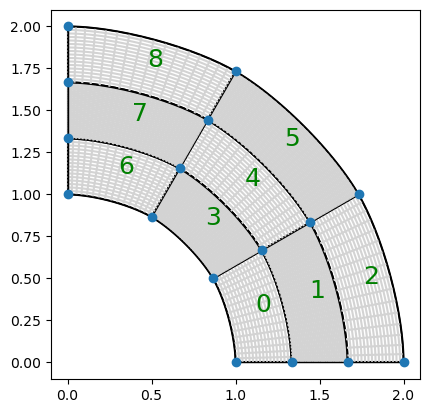

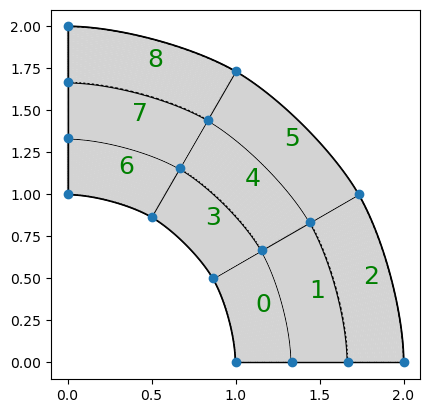

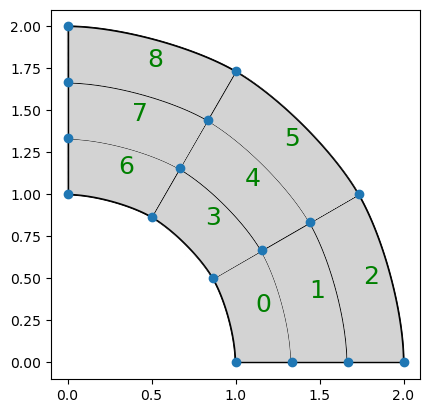

In [8]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(2,3,5,8)
maxiter=len(degs)*(6,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = checkerboard2(deg,2**(i+1),1)
        MP = assemble.Multipatch(M, automatch=True)
        MP.set_dirichlet_boundary({0:g})
        MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f=lambda x,y: 1.)
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        #res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_jumps()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="selection")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[i,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        res[i, k*j+1] = abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   
    else:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   

In [ ]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(2,3,4,5,6,7,8)
maxiter=len(degs)*(6,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for d in range(maxiter[j]):
        M = checkerboard1(deg,2,d+1)
        MP = assemble.Multipatch(M, automatch=True)
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f=lambda x,y: 1.)
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        #res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_jumps()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="choice")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[d,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=100, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        res[d, k*j+1] = abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   
    else:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   

In [10]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(2,3,5,8)
maxiter=len(degs)*(6,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = Lshape(deg,2**(i+1),5)
        MP = assemble.Multipatch(M, automatch=True)
        #res[i,k*j] = MP.N_ofs[-1]
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f=lambda x,y: 1.)
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        #res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_jumps()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="selection")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        #x0=np.random.rand(len(b))
        x0=None
        lam, res[i,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=x0, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        #print(min_eig, max_eig)
        res[i,k*j+1]=abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        if fat:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim_fat.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ")   
        else:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ") 
    else:
        np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ")   

deg = 2
setting up constraints took 0.14468860626220703 seconds.
Basis setup took 0.01755976676940918 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 7.744509695563973 stopped after 16 iterations with relres 7.96877293352872e-07
#####################################################
setting up constraints took 0.1415708065032959 seconds.
Basis setup took 0.017683744430541992 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 12.143176931946217 stopped after 19 iterations with relres 6.801701881551699e-07
#####################################################
setting up constraints took 0.15468263626098633 seconds.
Basis setup took 0.020795106887817383 seconds
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 17.307182041292084 stopped after 22 iterations with relres 6.840230228881076e-07
#####################################################
setting up constraints took 0.17935419082641602 seconds.
Basis set

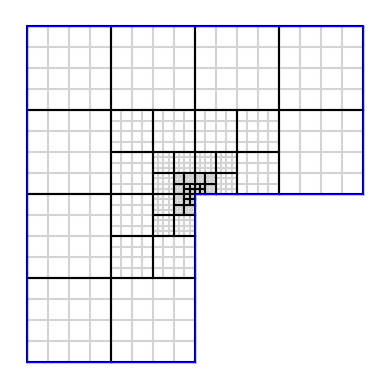

In [27]:
M = Lshape(1,4,5)
M.draw(bcolor={0:'blue'}, nodes=0, knots=1)
axis('off');

In [8]:
I.Ck

[<1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <3x49 sparse matrix of type '<class 'numpy.float64'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 <1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compr

In [9]:
I.Prim

{0: (array([ 48, 189, 202, 245], dtype=int32), array([1., 1., 1., 1.])),
 1: (array([ 97, 336, 349, 392], dtype=int32), array([1., 1., 1., 1.])),
 2: (array([140, 342, 398, 490], dtype=int32), array([1., 1., 1., 1.])),
 3: (array([146, 483, 496, 539], dtype=int32), array([1., 1., 1., 1.])),
 4: (array([ 55, 244, 287, 294], dtype=int32), array([1., 1., 1., 1.]))}

In [10]:
MP.get_nodes()

{48: [array([ 48, 189, 202, 245], dtype=int32)],
 96: [array([ 97, 336, 349, 392], dtype=int32)],
 138: [array([140, 342, 398, 490], dtype=int32)],
 144: [array([146, 483, 496, 539], dtype=int32)],
 252: [array([ 55, 244, 287, 294], dtype=int32)]}

#####################################
setting up constraints took 0.018363237380981445 seconds.
Basis setup took 0.009409666061401367 seconds
4
10
pcg with preconditioned condition number 1.1104232399228329 stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00043201446533203125 seconds for 9 patches.
setting up constraints took 0.020048141479492188 seconds.
Basis setup took 0.009725570678710938 seconds
7
26
pcg with preconditioned condition number 1.242827242377967 stopped after 6 iterations with relres 9.877262513024327e-15
Refinement took 0.000331878662109375 seconds for 9 patches.
setting up constraints took 0.023079395294189453 seconds.
Basis setup took 0.01008152961730957 seconds
8
23
pcg with preconditioned condition number 1.3131180431114824 stopped after 6 iterations with relres 7.19027091678448e-11
Refinement took 0.0003571510314941406 seconds for 9 patches.
setting up constraints took 0.029850244522094727 seconds.
Basis setup took 0.01311326026916

/home/wolfman/anaconda3/lib/python3.9/site-packages/pyiga-0.1.0-py3.9-linux-x86_64.egg/pyiga/topology.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=kwargs.get('figsize'))


21
25
pcg with preconditioned condition number 1.769266987585349 stopped after 11 iterations with relres 2.2424118613517237e-11
Refinement took 0.0003402233123779297 seconds for 9 patches.
setting up constraints took 0.03714632987976074 seconds.
Basis setup took 0.018062114715576172 seconds
24
24
pcg with preconditioned condition number 1.7675684065257513 stopped after 11 iterations with relres 8.781202012645705e-11
Refinement took 0.00039577484130859375 seconds for 9 patches.
setting up constraints took 0.06232929229736328 seconds.
Basis setup took 0.034009695053100586 seconds
25
24
pcg with preconditioned condition number 1.7590407403296329 stopped after 12 iterations with relres 2.639155553047284e-11
Refinement took 0.00043511390686035156 seconds for 9 patches.
setting up constraints took 0.11404061317443848 seconds.
Basis setup took 0.09270548820495605 seconds


KeyboardInterrupt: 

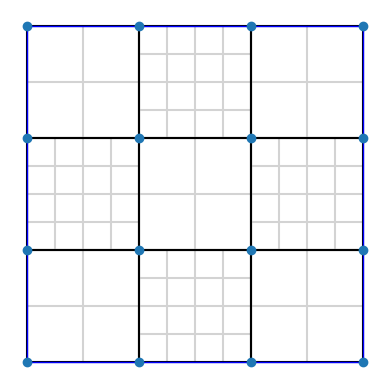

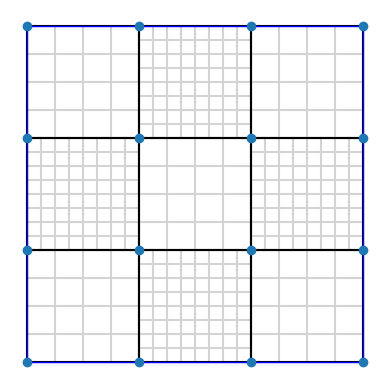

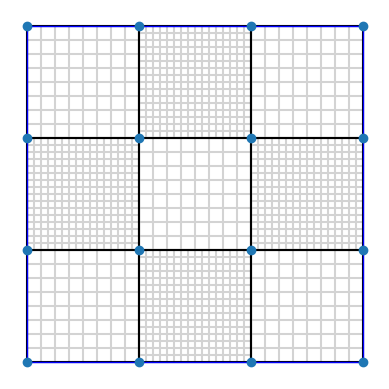

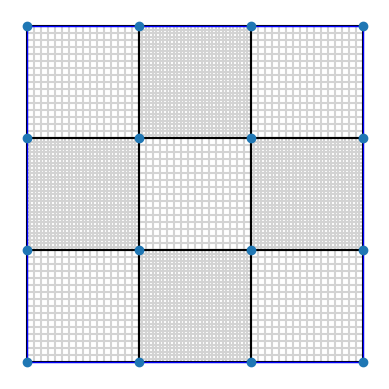

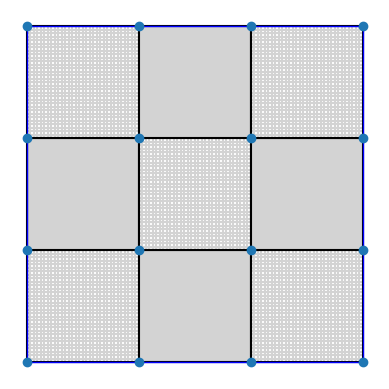

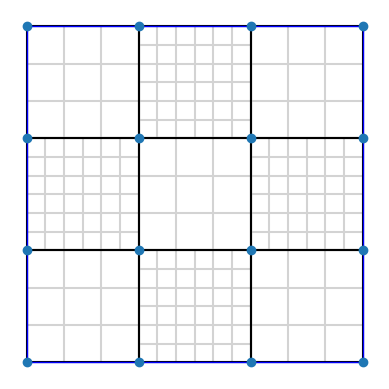

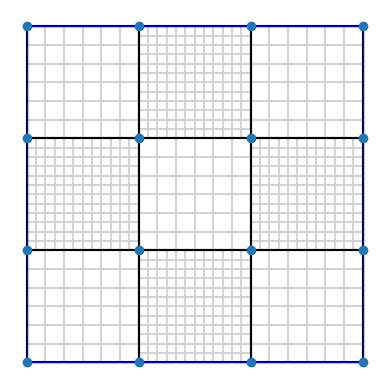

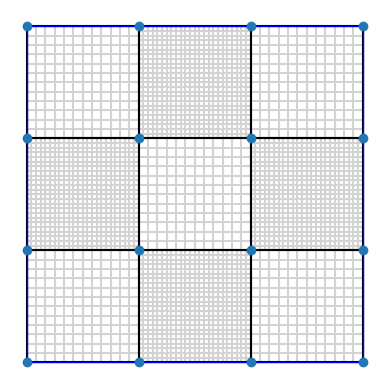

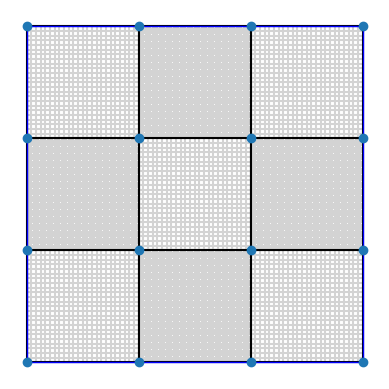

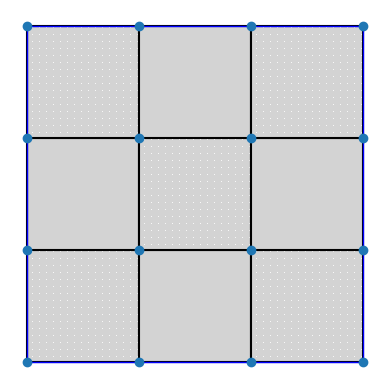

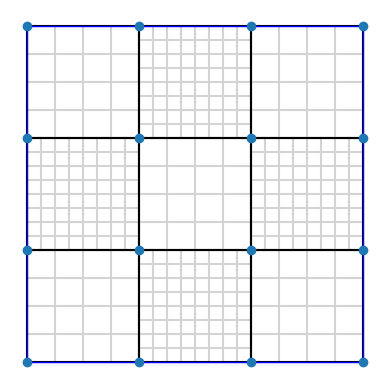

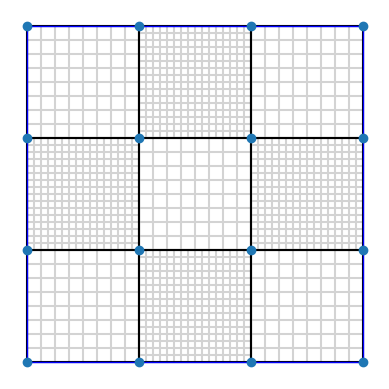

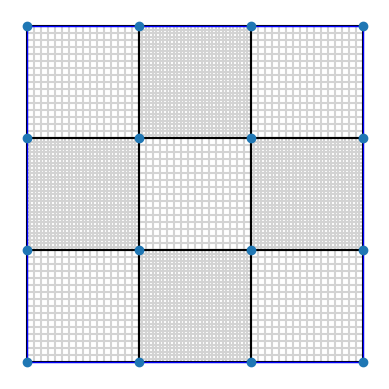

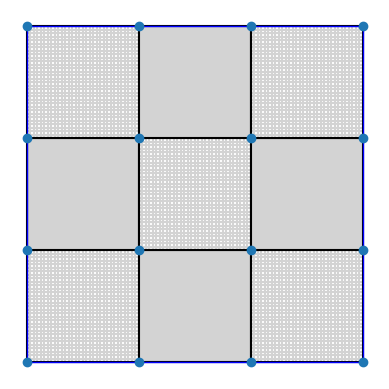

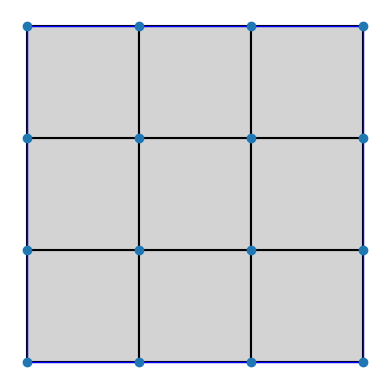

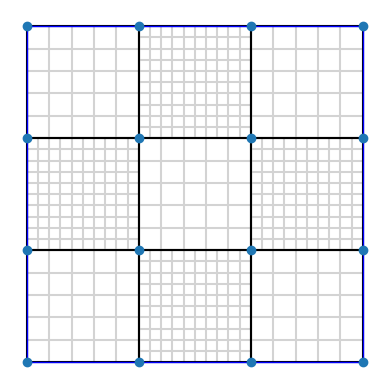

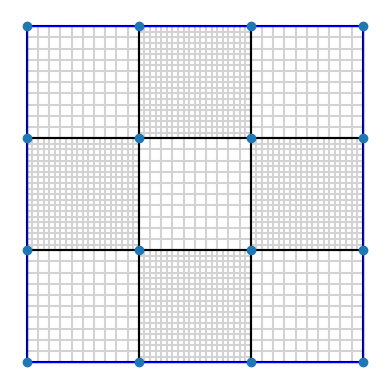

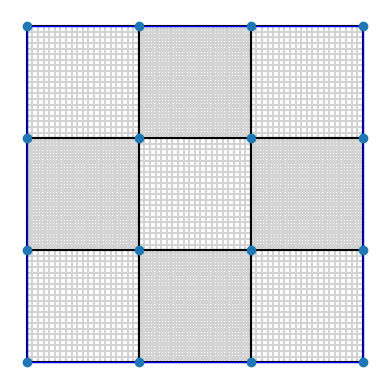

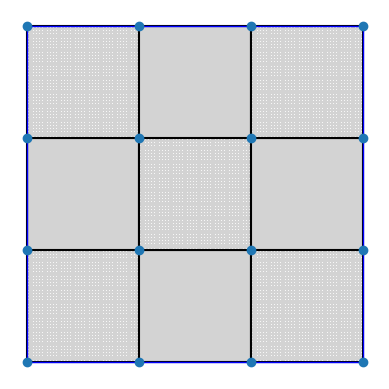

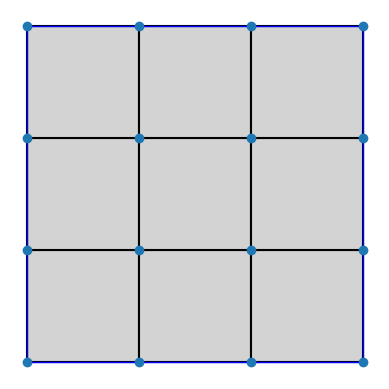

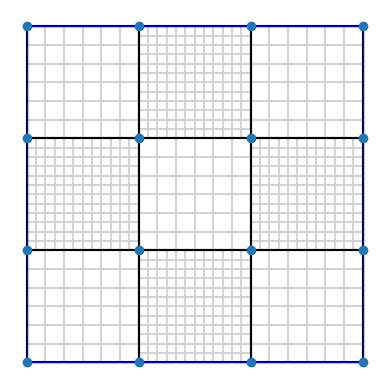

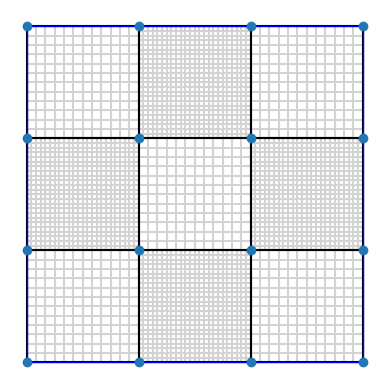

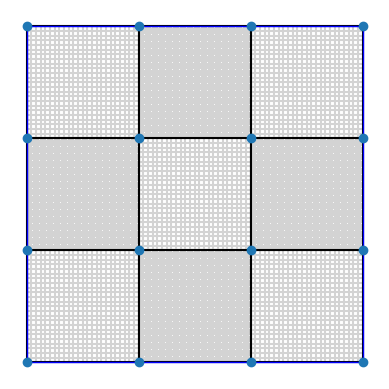

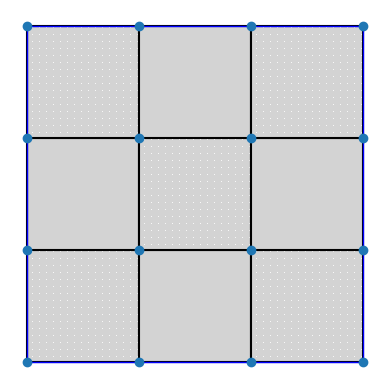

In [16]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=True)
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.017437458038330078 seconds.
Basis setup took 0.009253501892089844 seconds
pcg stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00016951560974121094 seconds for 4 patches.
setting up constraints took 0.01792740821838379 seconds.
Basis setup took 0.00933218002319336 seconds
pcg stopped after 4 iterations with relres 4.273988115438311e-17
Refinement took 0.0001652240753173828 seconds for 4 patches.
setting up constraints took 0.019681930541992188 seconds.
Basis setup took 0.009746074676513672 seconds
pcg stopped after 4 iterations with relres 9.358588499822341e-15
Refinement took 0.00015854835510253906 seconds for 4 patches.
setting up constraints took 0.021558284759521484 seconds.
Basis setup took 0.011844396591186523 seconds
pcg stopped after 4 iterations with relres 4.58228236822898e-13
Refinement took 0.00017547607421875 seconds for 4 patches.
setting up constraints took 0.02753949165344

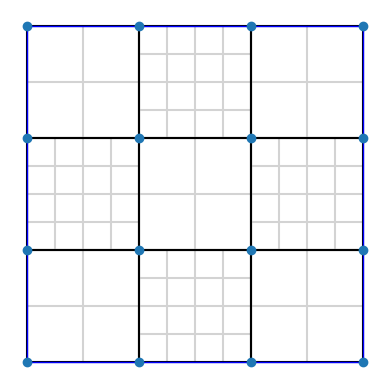

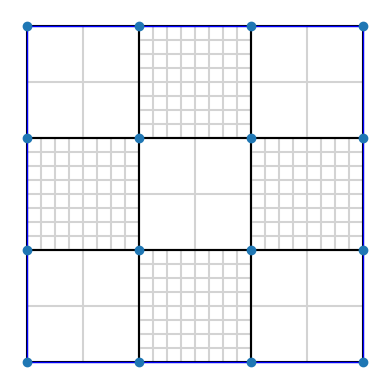

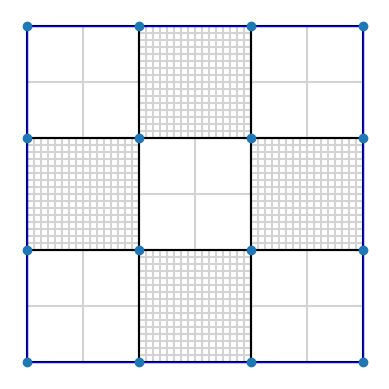

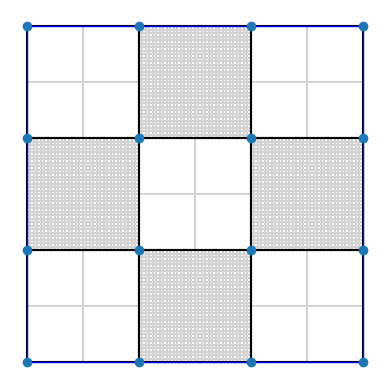

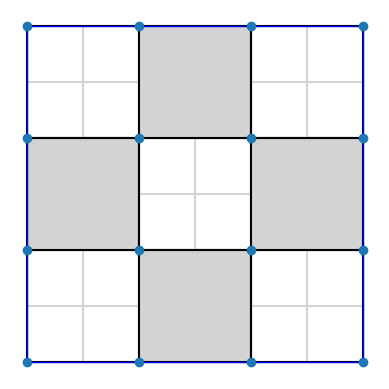

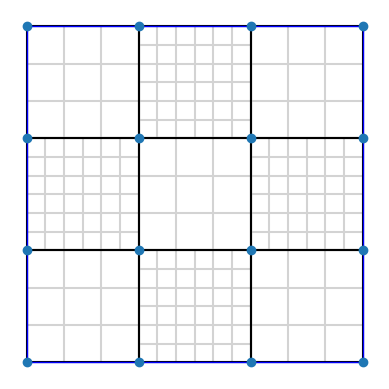

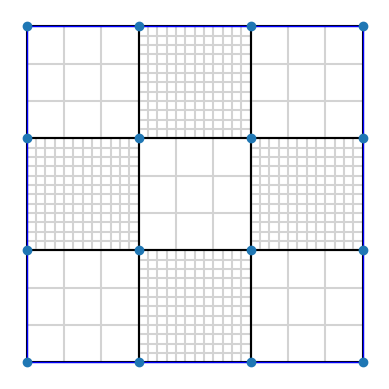

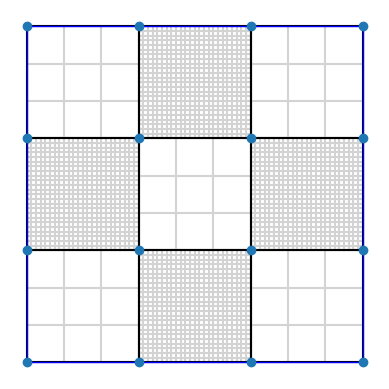

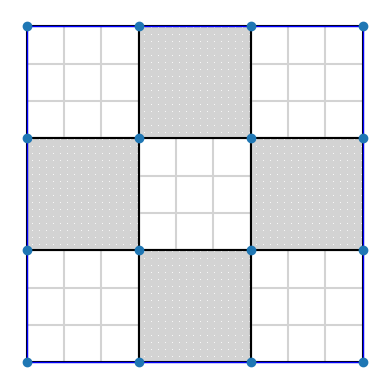

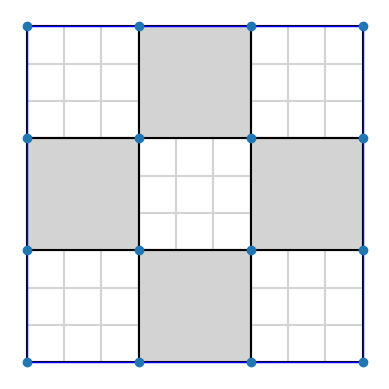

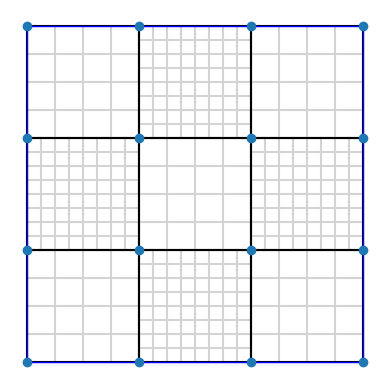

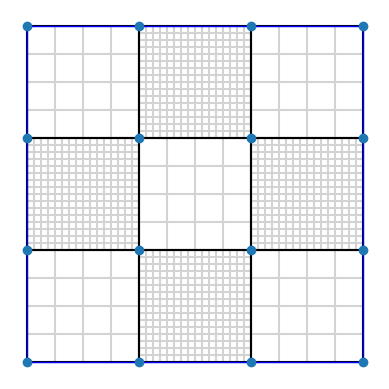

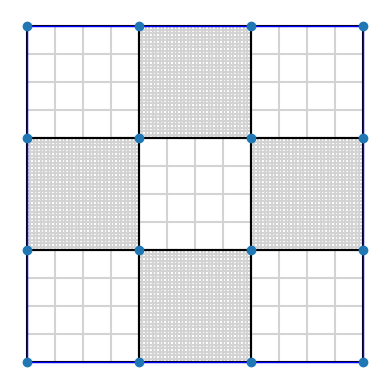

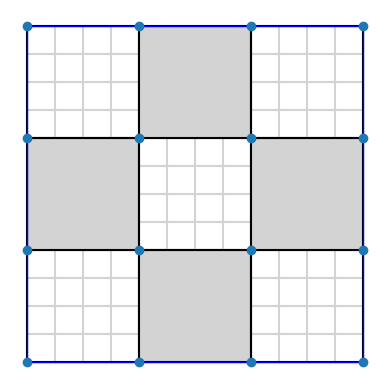

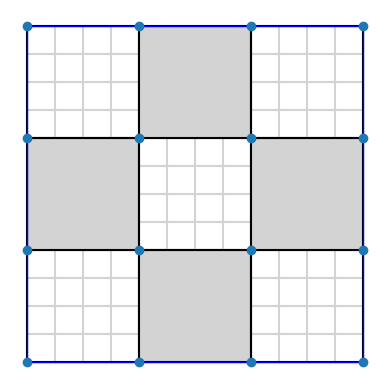

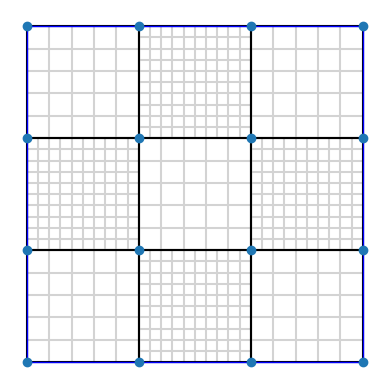

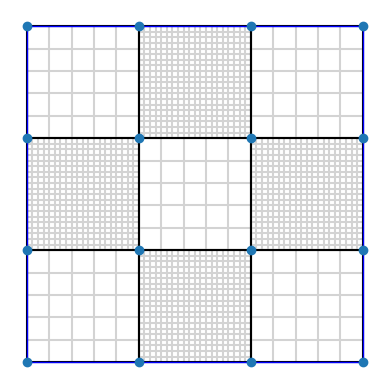

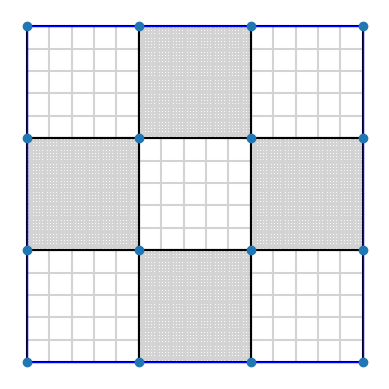

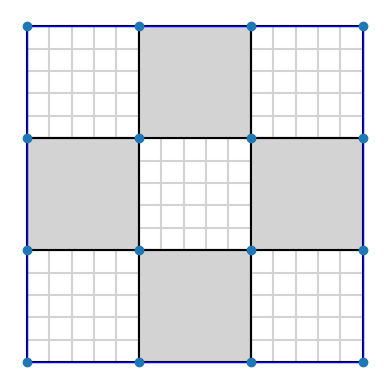

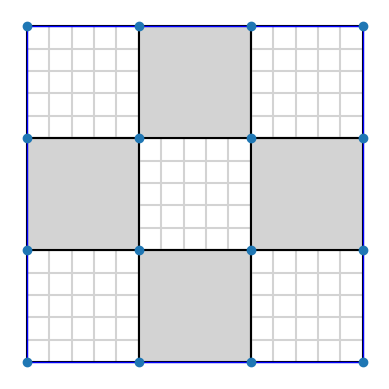

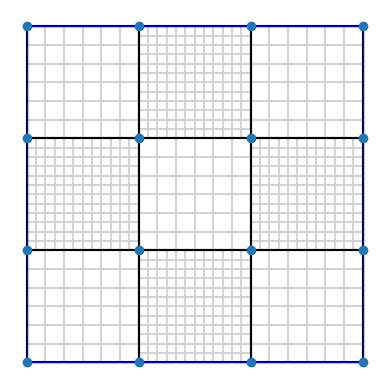

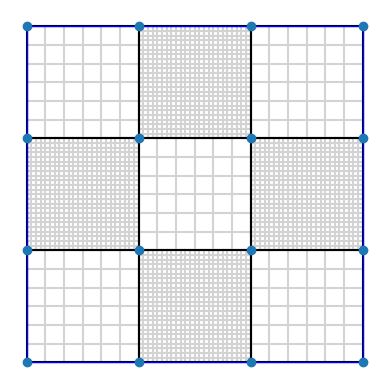

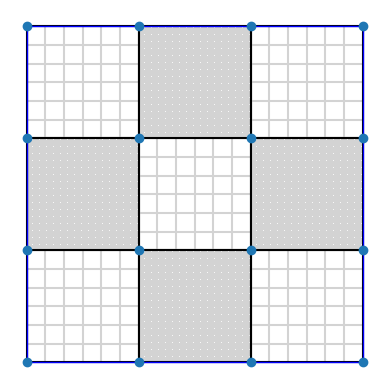

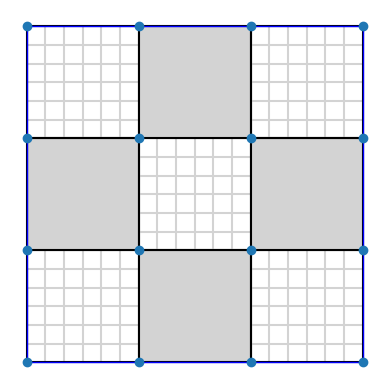

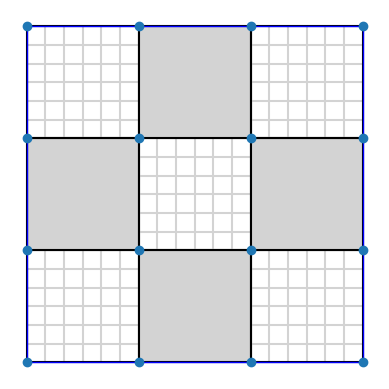

In [49]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD()
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        ###MP.h_refine(-1)
        MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

In [ ]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((6,5))
it = np.zeros((6,5))
elim=True

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(6,))):
    print('#####################################')
    M = Lshape(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=False)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.08600449562072754 seconds.
Basis setup took 0.014266014099121094 seconds
pcg with preconditioned condition number 1.0972303562262358 stopped after 5 iterations with relres 2.1033830757006824e-11
Refinement took 0.0010564327239990234 seconds for 31 patches.
setting up constraints took 0.07834243774414062 seconds.
Basis setup took 0.013842582702636719 seconds
pcg with preconditioned condition number 1.671463683434546 stopped after 10 iterations with relres 4.9938397508517634e-11
Refinement took 0.0012252330780029297 seconds for 31 patches.
setting up constraints took 0.08354926109313965 seconds.
Basis setup took 0.015346527099609375 seconds
pcg with preconditioned condition number 1.2749844484684212 stopped after 13 iterations with relres 3.0492980297062935e-11
Refinement took 0.00106048583984375 seconds for 31 patches.
setting up constraints took 0.1029202938079834 seconds.
Basis setup took 0.020825624465942383 seconds
